In [103]:
import sys
import scipy.io.wavfile as wav
from scipy import stats as stats
import math
# from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt
import struct
import pandas as pd
import itertools
import pyaudio
import wave
import sys
import hashlib
import rsa
import sha3
from Crypto.PublicKey import RSA as krypto
from Crypto.Cipher import PKCS1_OAEP as pkcs
import random

In [2]:
N = 1038622
temparray = np.array([0.141592, 0.653589, 0.793238, 0.462643, 0.383279, 0.502884, 0.197169, 0.399375], dtype='double')
x = np.array([[0 for w in range(8)] for z in range (4)], dtype='double')
for y in range (8):
    x[0][y] = temparray[y]
L = 8
alpha = 1.99999
gamma = 4
epsilon = 0.05
s = 64
n = (2*N)/s
A = []
B = []
Pre = []
O = []
z = np.array([0 for w in range(7)])
weight = 0.5
b = 3

In [ ]:
# # # # ZBIERANIE SZUMU Z MIKROFONU # # # #


# CHUNK = 1024
# FORMAT = pyaudio.paInt16
# CHANNELS = 2
# RATE = 44100
# RECORD_SECONDS = 10
# WAVE_OUTPUT_FILENAME = "output.wav"

# p = pyaudio.PyAudio()

# stream = p.open(format=FORMAT,
#                 channels=CHANNELS,
#                 rate=RATE,
#                 input=True,
#                 frames_per_buffer=CHUNK)

# print("* recording")

# frames = []

# for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
#     data = stream.read(CHUNK)
#     frames.append(data)

# print("* done recording")

# stream.stop_stream()
# stream.close()
# p.terminate()

# wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
# wf.setnchannels(CHANNELS)
# wf.setsampwidth(p.get_sample_size(FORMAT))
# wf.setframerate(RATE)
# wf.writeframes(b''.join(frames))
# wf.close()

In [114]:
# # # # FUNKCJE # # # #

def extract(data):
    with open(data, 'rb') as fh:
        bits = True
        i = 0
        while bits:
            i = i+1
            bits = fh.read(1)
            if (i>=10000):
                temp = (bin(int.from_bytes(bits, byteorder=sys.byteorder))[2:]).zfill(8)[5:]
                temppre = (bin(int.from_bytes(bits, byteorder=sys.byteorder))[2:]).zfill(8)
                tempMiBiS = (bin(int.from_bytes(bits, byteorder=sys.byteorder))[2:]).zfill(8)[7:]
                A.append(int(temp, 2))
                B.append(int(tempMiBiS, 2))
                Pre.append(int(temppre, 2))
            if (i==N):
                bits = False   

def perturbation(i, t, c):
    tempchaos = x[t][i]
    tempchaos = (((weight * A[c]) / ((2 ** b) - 1)) + tempchaos) * (1.0 / (1.0 + weight))
    x[t][i] = tempchaos

def chaosfun(i, t):
    if (x[t][i]<(0.5)):
        return alpha*x[t][i]
    else:
        return alpha * (1 - x[t][i])

def chaosmap(i, t):
    tempchaos = ((1 - epsilon) * chaosfun(i, t)) + ((epsilon / 2) * ((chaosfun((i + 1) % L, t)) + (chaosfun((i - 1) % L, t))))
    x[t+1][i] = tempchaos

def swap(number):
    # print(number)
    num = int(bin(number), 2)
    # print(num)
    mask = 0b11110000
    mask2 = 0b00001111
    tempmasked = mask & num
    temp1 = tempmasked >> 4
    tempmasked2 = mask2 & num
    temp2 = tempmasked2 << 4
    numero = temp1 | temp2
    # print(type(numero))
    return numero

def convert(num):
    temp = np.array([num], dtype='double')
    tamp = np.frombuffer(temp, dtype='uint8')
    return tamp[0]

def count_entropy(input):
    value,counts = np.unique(input, return_counts=True)
    # print(counts/sum(counts))
    end = 0
    for i in range(len(counts)):
        e = (counts[i]/sum(counts))*math.log2((counts[i]/sum(counts)))
        end = end + e
    entropy = -end
    return entropy

def toBytes(input):
    bytes = [sum([byte[b] << b for b in range(0,8)])
            for byte in zip(*(iter(input),) * 8)
        ]
    return bytes

def toBits(input):
    arr = list(map(int, input))
    for i in range(len(arr)):
        arr[i] = str(bin(arr[i])[2:]).zfill(3)
    temp = "".join(arr)
    return temp

def cutBitString(input):
    str = input
    bitarr = np.array([], 'int')
    temparr = [str[i:i+8] for i in range (0,(len(str)-len(str)%8),8)]
    print(len(temparr))
    for i in range (0, len(temparr)):
        bitarr = np.append(bitarr, int(temparr[i], 2))
        # if(i%5==0):
        #     print(i)
    return bitarr
    
def generateKeys():
    (publicKey, privateKey) = rsa.newkeys(1024)
    with open('publicKey.pem', 'wb') as p:
        p.write(publicKey.save_pkcs1('PEM'))
    with open('privateKey.pem', 'wb') as p:
        p.write(privateKey.save_pkcs1('PEM'))

def loadKeys():
    with open('publicKey.pem', 'rb') as p:
        publicKey = rsa.PublicKey.load_pkcs1(p.read())
    with open('privateKey.pem', 'rb') as p:
        privateKey = rsa.PrivateKey.load_pkcs1(p.read())
    return publicKey, privateKey

def encrypt(message, key):
    return rsa.encrypt(message.encode('ascii'), key)

def decrypt(ciphertext, key):
    try:
        return rsa.decrypt(ciphertext, key).decode('ascii')
    except:
        return False

def sign(message, key):
    return rsa.sign(message.encode('ascii'), key, 'SHA-256')

def verify(message, signature, key):
    try:
        return rsa.verify(message.encode('ascii'), signature, key,) == 'SHA-256'
    except:
        return False

In [86]:
extract("output.wav")
counter = 0
while(counter < (N - 10008)):
    for i in range(L-1):
        perturbation(i, 0, counter)
        counter = counter + 1
    # print(x)
    # break
    for t in range(gamma - 1):
        for i in range(L - 1):
            chaosmap(i, t)
    # break
    # print(x)
    for i in range (L-1):
        z[i] = convert(x[gamma - 1][i])
        x[0][i] = x[gamma - 1][i]
    ztemp = 0
    # (L / 2) - 1 = 3
    for i in range(3):
        z[i] = np.uint8(int(bin(z[i]), 2)) ^ swap(z[i + int(L / 2)])
        O.append(z[i])

Omess = O[0]<<8 | O[1]
print(Omess)

# print(O)

14553


In [115]:
str = "ChujCiwDupeStanoski"


encoded_str = str.encode()
obj_sha3_256 = hashlib.sha3_256(encoded_str)
print("\nSHA3-256 Hash: ", obj_sha3_256.hexdigest())



with open('binaryStream.txt', 'wb') as f:
    np.save(f, O)

with open('binaryStream.txt', 'rb') as p:
    key = krypto.generate(1024, p.read)

private_key = key.export_key()
file_out = open("privateKey.pem", "wb")
file_out.write(private_key)
file_out.close()

public_key = key.publickey().export_key()
file_out = open("publicKey.pem", "wb")
file_out.write(public_key)
file_out.close()

# generateKeys()
publicKey, privateKey = loadKeys()

message = obj_sha3_256.hexdigest()
ciphertext = encrypt(message, publicKey)

signature = sign(message, privateKey)

text = decrypt(ciphertext, privateKey)

print(f'Cipher text: {ciphertext}')
print(f'Signature: {signature}')

if text:
    print(f'Message text: {text}')
else:
    print(f'Unable to decrypt the message.')

if verify(text, signature, publicKey):
    print("Successfully verified signature")
else:
    print('The message signature could not be verified')




SHA3-256 Hash:  2bf3e60b96490000997ac047e99cc98209b4a7b38fe25a45b005d1fd3601bd7d


AttributeError: type object 'PrivateKey' has no attribute 'load_pkcs1_openssl_pem'

In [77]:
from math import gcd
import random
from random import randint
import sys

def encodeMessage(msg):
    encodedMsg = 0

    for char in msg:
        encodedMsg = encodedMsg << 8
        encodedMsg = encodedMsg ^ ord(char)
    return encodedMsg

def getRandomPrime(primeSize):
    for i in range(len(O)):
        x = O[i]
    while not (isPrime(x)):
        x = O[i] 
    return x
    
def isPrime(n):
    if n % 2 == 0:
        return False

    for i in range(1, 40):
        a = random.randint(1, n - 1)
        if isComposite(a, n):
            return False
    return True

def isComposite(a, n):
    
    t,d = decompose(n - 1)
    x = a**d**n
    
    if x == 1 or x == n - 1:
        return False

    for i in range(1, t):
        x0 = x;
        x = pow(x0, 2, n)
        if x == 1 and x0 != 1 and x0 != n - 1:
            return True
    if x != 1:
        return True
        
    return False

def decompose(n):
    i = 0
    while n & (1 << i) == 0:
        i += 1
    return i, n >> i

def getKeys(p, q):
    n = p * q
    phi = (p - 1) * (q - 1)
    for i in range(2, phi):
        if gcd(phi,i) == 1:
            e = i
            break
         
    d = multiplicativeInverse(e, phi)
    
    return n, e, d

def multiplicativeInverse(e, phi):
    return extendedEuclid(e, phi)[1] % phi

def extendedEuclid(a, b):
    if b == 0:
        return a, 1, 0
    else: 
        d2, x2, y2 = extendedEuclid(b, a % b)
        d, x, y = d2, y2, x2 - (a // b) * y2
        return d, x, y



try:
    modulusSize = int(sys.argv[1])
        
except:
    modulusSize = 1024

msg = "Hello, World!"

primeSize = modulusSize // 2
p = getRandomPrime(primeSize)
q = getRandomPrime(primeSize)
while p == q:
    q = getRandomPrime(primeSize)

n, e, d = getKeys(p, q)

encodedMsg = encodeMessage(msg)
encryptedMsg = pow(encodedMsg, e, n)
decryptedMsg = pow(encryptedMsg, d, n)

print("Public key (e, n):")
print("\te = ", e)
print("\tn = ", n)
print("\nPrivate key (d, n):")
print("\td = ", d)
print("\tn = ", n)
print("\nOriginal message string:\n\t", msg)
print("\nInteger encoded message:\n\t", encodedMsg)
print("\nEncrypted message( C(M) = M^e % n ):\n\t", encryptedMsg)
print("\nDecrypted message( M(C) = C^d % n ):\n\t", decryptedMsg)
if encodedMsg == decryptedMsg:
    print("\nThe decrypted message and the original encoded message match.")

ValueError: Integers to negative integer powers are not allowed.

In [ ]:
# arrMiBiS = np.array([], dtype = 'int')
# arrMiBiS = np.append(arrMiBiS, B[0])
# arrMiBiS = np.append(arrMiBiS, B[1])
# arrMiBiS = np.insert(arrMiBiS, 1, B[2])
# step=3
# i=3
# control = (2**step) + 1
# while((i <= len(B)) and (control < len(B))):
#     control = (2**step) + 1
#     newBits = 2**(step-2)
#     counterOdd = 2
#     counterEven = 2
#     for j in range ((int(newBits/2))-1):
#         arrMiBiS = np.insert(arrMiBiS, counterOdd, B[i])
#         arrMiBiS = np.insert(arrMiBiS, -counterEven, B[i+1])
#         counterOdd = counterOdd + 2
#         counterEven = counterEven + 2
#         i = i+2
#     step = step + 1
#     i = i+1

# counterXOR = 0
# p = np.array([], dtype = 'int')
# while(counterXOR < len(arrMiBiS)):
#     XORek = arrMiBiS[counterXOR] ^ B[counterXOR]
#     p = np.append(p, XORek)
#     counterXOR = counterXOR + 1
# # print(p)
# bajty = toBytes(p)
# # print(bajty)

Entropia Chaosmap: 7.999642772733402
Entropia przed post-processingiem: 6.997384625833351
672596


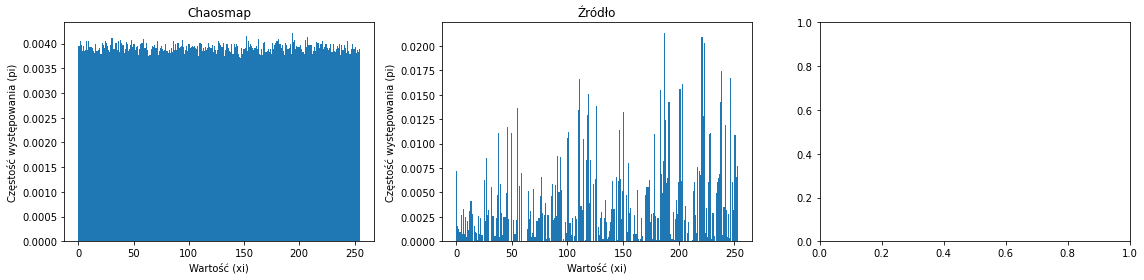

In [ ]:
bithist = toBits(A)
result = cutBitString(bithist)

print("Entropia Chaosmap:", count_entropy(O))
print("Entropia MiBiS&XOR:", count_entropy(bajty))
# print("Entropia szumu na wyjściu mikrofonu:", count_entropy(Pre))
# print("Entropia źródła:", count_entropy(result))




fig, axs = plt.subplots(1,3, figsize = (16, 4))
axs[0].hist(O, bins=256, density = True)
axs[0].set_title('Chaosmap')
axs[0].set_xlabel('Wartość (xi)')
axs[0].set_ylabel('Częstość występowania (pi)')
axs[1].hist(result, bins=256, density = True)
axs[1].set_title('Źródło')
axs[1].set_xlabel('Wartość (xi)')
axs[1].set_ylabel('Częstość występowania (pi)')
axs[2].hist(bajty, bins=256, density = True)
axs[2].set_title('MiBiS&XoR')
axs[2].set_xlabel('Wartość (xi)')
axs[2].set_ylabel('Częstość występowania (pi)')
plt.tight_layout()
plt.show()
